# Exploring thermal behaviour

Thomas Schanzer  
January 2022

In this notebook, we test the behaviour of our scheme's ascending and descending thermals in different soundings and with different initial conditions and entrainment rates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import pandas as pd
from scipy.interpolate import interp1d
import sys

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
import metpy.constants as const

from dparcel.environment import idealised_sounding
from dparcel.thermo import saturation_specific_humidity, equivalent_potential_temperature
sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator

## Soundings

We use soundings from Williamtown NSW at 0 UTC (1100 AEDT) on 21 December 2021 and Changi Airport, Singapore at 0 UTC (0800 UTC+8) on 1 December 2021, which both have fairly large CAPE.

Our scheme struggles on sounding data with irregular pressure level spacing, so we interpolate the data to a uniform spacing of 5 mbar.

In [2]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
sounding = pd.read_fwf(
    file, names=['p_wtown', 'z_wtown', 't_wtown', 'td_wtown'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[::-1,0]
height = sounding[::-1,1]
temperature = sounding[::-1,2]
dewpoint = sounding[::-1,3]

p_wtown = np.arange(pressure[0], pressure[-1], 5)*units.mbar
z_wtown = interp1d(pressure, height)(p_wtown)*units.meter
t_wtown = interp1d(pressure, temperature)(p_wtown)*units.celsius
td_wtown = interp1d(pressure, dewpoint)(p_wtown)*units.celsius
q_wtown = mpcalc.specific_humidity_from_dewpoint(p_wtown, td_wtown)
wtown = ThermalGenerator(
    p_wtown, z_wtown, t_wtown, q_wtown)

file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(
    file, names=['p_sgp', 'z_sgp', 't_sgp', 'td_sgp'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[::-1,0]
height = sounding[::-1,1]
temperature = sounding[::-1,2]
dewpoint = sounding[::-1,3]

p_sgp = np.arange(pressure[0], pressure[-1], 5)*units.mbar
z_sgp = interp1d(pressure, height)(p_sgp)*units.meter
t_sgp = interp1d(pressure, temperature)(p_sgp)*units.celsius
td_sgp = interp1d(pressure, dewpoint)(p_sgp)*units.celsius
q_sgp = mpcalc.specific_humidity_from_dewpoint(p_sgp, td_sgp)
sgp = ThermalGenerator(p_sgp, z_sgp, t_sgp, q_sgp)

In [3]:
profile_wtown = mpcalc.parcel_profile(p_wtown[::-1], t_wtown[-1], td_wtown[-1])
cape_wtown, cin_wtown = mpcalc.cape_cin(
    p_wtown[::-1], t_wtown[::-1], td_wtown[::-1], profile_wtown)

profile_sgp = mpcalc.parcel_profile(p_sgp[::-1], t_sgp[-1], td_sgp[-1])
cape_sgp, cin_sgp = mpcalc.cape_cin(
    p_sgp[::-1], t_sgp[::-1], td_sgp[::-1], profile_sgp)

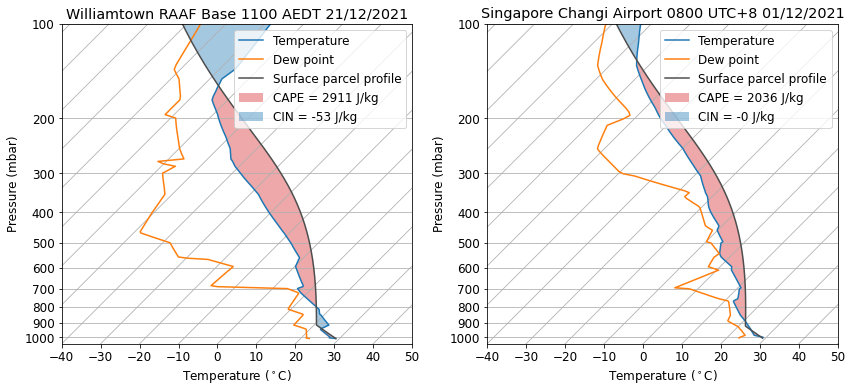

In [4]:
fig = plt.figure(figsize=(12,6))

skew = SkewT(fig, rotation=45, subplot=(1,2,1))
skew.plot(p_wtown, t_wtown, label='Temperature')
skew.plot(p_wtown, td_wtown, label='Dew point')
skew.plot(p_wtown, profile_wtown[::-1], '0.3', label='Surface parcel profile')
skew.shade_cape(p_wtown, t_wtown, profile_wtown[::-1],
                label='CAPE = {:.0f} J/kg'.format(cape_wtown.m))
skew.shade_cin(p_wtown, t_wtown, profile_wtown[::-1],
                label='CIN = {:.0f} J/kg'.format(cin_wtown.m))
skew.ax.legend(loc='upper right')
skew.ax.set(xlabel='Temperature ($^\circ$C)', ylabel='Pressure (mbar)',
            title='Williamtown RAAF Base 1100 AEDT 21/12/2021')

skew = SkewT(fig, rotation=45, subplot=(1,2,2))
skew.plot(p_sgp, t_sgp, label='Temperature')
skew.plot(p_sgp, td_sgp, label='Dew point')
skew.plot(p_sgp, profile_sgp[::-1], '0.3', label='Surface parcel profile')
skew.shade_cape(p_sgp, t_sgp, profile_sgp[::-1],
                label='CAPE = {:.0f} J/kg'.format(cape_sgp.m))
skew.shade_cin(p_sgp, t_sgp, profile_sgp[::-1],
                label='CIN = {:.0f} J/kg'.format(cin_sgp.m))
skew.ax.legend(loc='upper right')
skew.ax.set(xlabel='Temperature ($^\circ$C)', ylabel='Pressure (mbar)',
            title='Singapore Changi Airport 0800 UTC+8 01/12/2021')

fig.tight_layout()

## Updrafts

We generate ascending thermals by adding temperature perturbations to environmental parcels in both soundings, with all other parameters remaining at their environmental values. We vary the starting level and the magnitude of the temperature perturbation.

We also test two different entrainment rates: (2 km)$^{-1}$ and (10 km)$^{-1}$, which according to Sherwood et al. (2013) are typical strong and weak entrainment rates respectively; the former is characteristic of thermals in observations and CRM output, while the latter is characteristic of the values assumed in standard convection parametrisations.

### Strong entrainment, no drag: $\epsilon$ = (2 km)$^{-1}$

In [5]:
%%time
z_init = np.arange(0, 2.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
i_init_wtown[0] -= 3
i_init_sgp[0] -= 3
t_pert = np.arange(0.3, 3.1, 0.3)*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.5/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 1e-3*units.dimensionless

updrafts_wtown = np.empty((z_init.size, t_pert.size), dtype='object')
updrafts_sgp = np.empty((z_init.size, t_pert.size), dtype='object')
n_done = 0
n_tot = z_init.size*t_pert.size*2
for i in range(z_init.size):
    for j in range(t_pert.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_wtown[i,j] = wtown.updraft(
            i_init_wtown[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, drag, l_crit)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_sgp[i,j] = sgp.updraft(
            i_init_sgp[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, drag, l_crit)
sys.stdout.write('\n')

Calculation 100 of 100     
CPU times: user 30.9 s, sys: 121 ms, total: 31.1 s
Wall time: 31.1 s


1

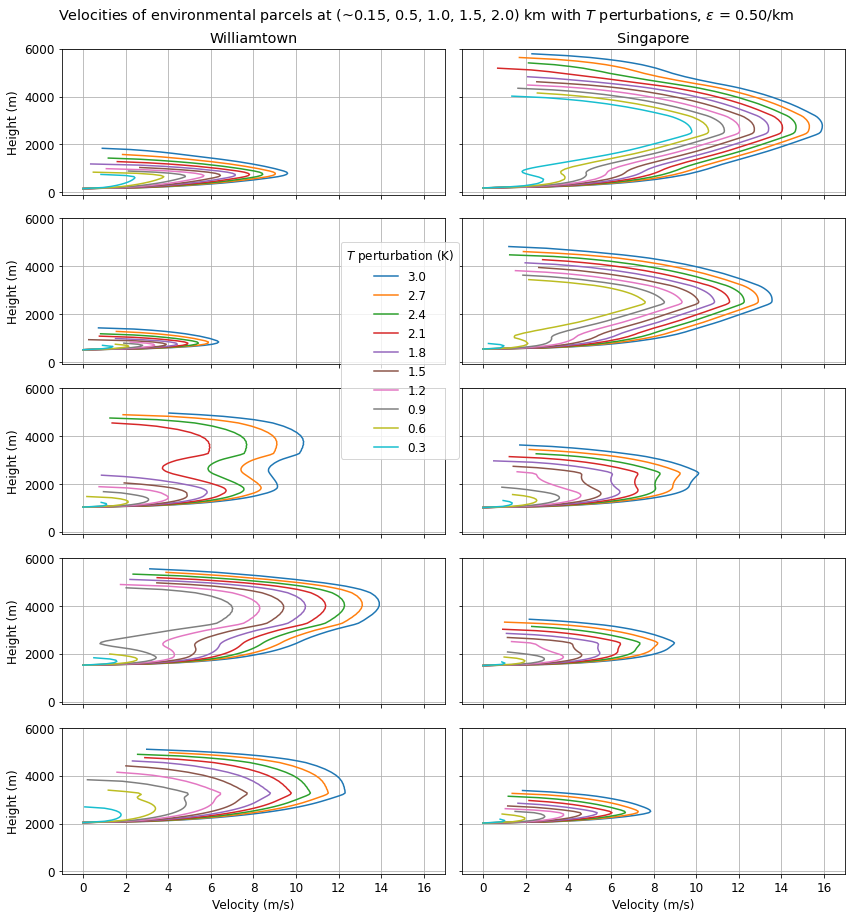

In [6]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(t_pert.size - 1, -1, -1):
        axes[i,0].plot(updrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(updrafts_sgp[i,j].velocity, z_sgp,
                       label='{:.1f}'.format(t_pert[j].m))
for ax in axes.ravel():
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-1, 17)
    ax.set_ylim(-100, 6000)
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.4, 0.5))
lgd.set_title('$T$ perturbation (K)')
fig.suptitle(
    'Velocities of environmental parcels at (~0.15, 0.5, 1.0, 1.5, 2.0) km '
    'with $T$ perturbations, $\epsilon$ = {:.2f}/km'.format(rate.m))
fig.tight_layout()

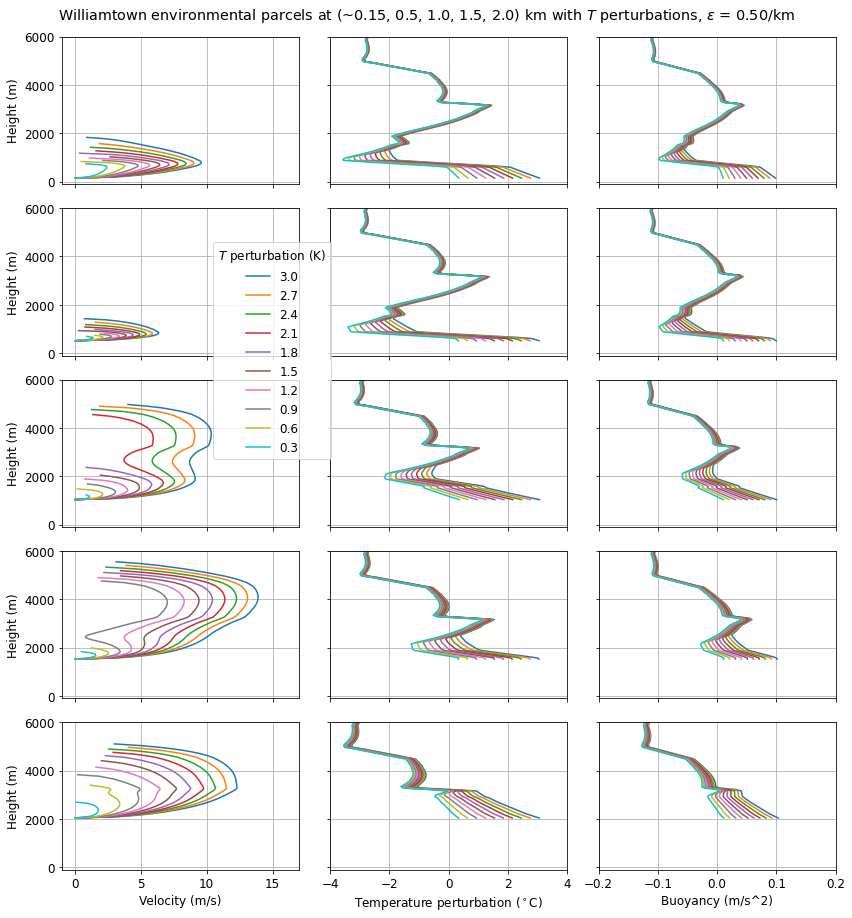

In [7]:
fig, axes = plt.subplots(z_init.size, 3, figsize=(12,13))
for i in range(z_init.size):
    for j in range(t_pert.size - 1, -1, -1):
        axes[i,0].plot(updrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(updrafts_wtown[i,j].temperature - t_wtown, z_wtown)
        axes[i,2].plot(updrafts_wtown[i,j].buoyancy, z_wtown,
                       label='{:.1f}'.format(t_pert[j].m))
for ax in axes.ravel():
    ax.grid()
    ax.set(ylabel='Height (m)')
    ax.set_ylim(-100, 6000)
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,0].ravel():
    ax.set_xlim(-1, 17)
for ax in axes[:,1].ravel():
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlim(-4, 4)
for ax in axes[:,2].ravel():
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[-1, 0].set(xlabel='Velocity (m/s)')
axes[-1, 1].set(xlabel='Temperature perturbation ($^\circ$C)')
axes[-1, 2].set(xlabel='Buoyancy (m/s^2)')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.25, 0.5))
lgd.set_title('$T$ perturbation (K)')
fig.suptitle(
    'Williamtown environmental parcels at (~0.15, 0.5, 1.0, 1.5, 2.0) km '
    'with $T$ perturbations, $\epsilon$ = {:.2f}/km'.format(rate.m))
fig.tight_layout()

### Weak entrainment: $\epsilon$ = (10 km)$^{-1}$

In [8]:
%%time
z_init = np.arange(0, 2.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
i_init_wtown[0] -= 3
i_init_sgp[0] -= 3
t_pert = np.arange(0.3, 3.1, 0.3)*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.1/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 1e-3*units.dimensionless

updrafts_wtown = np.empty((z_init.size, t_pert.size), dtype='object')
updrafts_sgp = np.empty((z_init.size, t_pert.size), dtype='object')
n_done = 0
n_tot = z_init.size*t_pert.size*2
for i in range(z_init.size):
    for j in range(t_pert.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_wtown[i,j] = wtown.updraft(
            i_init_wtown[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, drag, l_crit)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_sgp[i,j] = sgp.updraft(
            i_init_sgp[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, drag, l_crit)
sys.stdout.write('\n')

Calculation 100 of 100     
CPU times: user 33.7 s, sys: 142 ms, total: 33.8 s
Wall time: 33.9 s


1

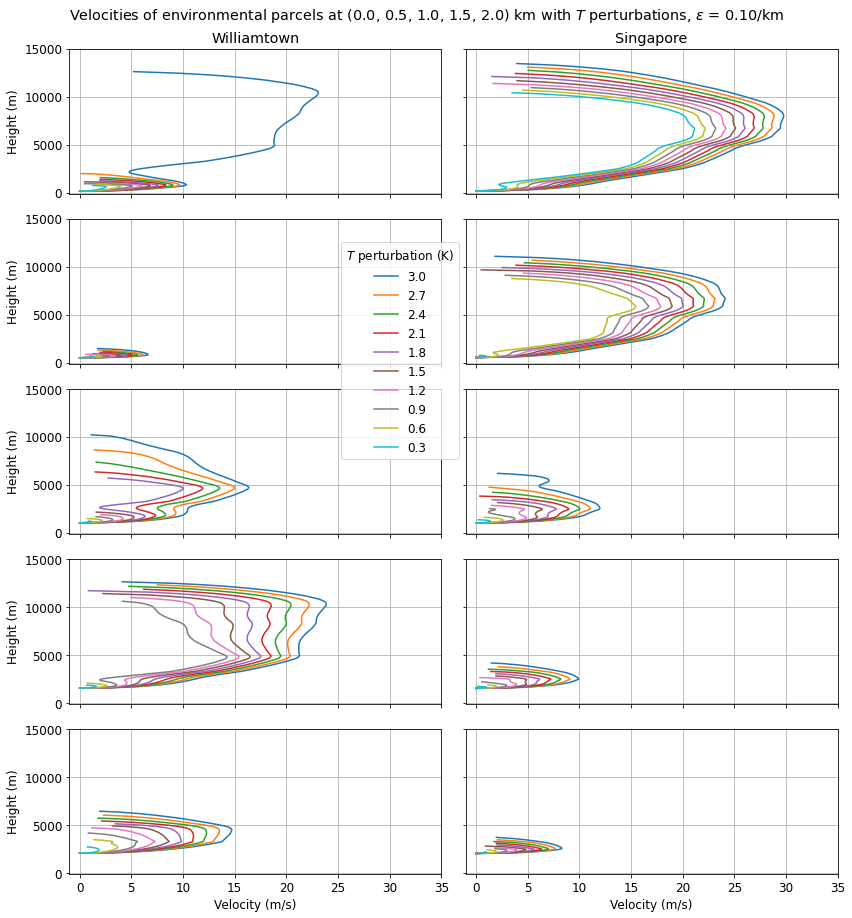

In [9]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(t_pert.size - 1, -1, -1):
        axes[i,0].plot(updrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(updrafts_sgp[i,j].velocity, z_sgp,
                       label='{:.1f}'.format(t_pert[j].m))
for ax in axes.ravel():
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-1, 35)
    ax.set_ylim(-100, 15000)
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.4, 0.5))
lgd.set_title('$T$ perturbation (K)')
fig.suptitle(
    'Velocities of environmental parcels at (0.0, 0.5, 1.0, 1.5, 2.0) km '
    'with $T$ perturbations, $\epsilon$ = {:.2f}/km'.format(rate.m))
fig.tight_layout()

## Downdrafts

We generate descending thermals by evaporating water into environmental parcels in both soundings. We vary the starting level and amount of water evaporated. Again, we test the strong and weak entrainment cases.

### Strong entrainment: $\epsilon$ = (2 km)$^{-1}$

In [10]:
%%time
z_init = np.arange(4.0, 6.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
delta_Q = np.arange(0.5e-3, 5.1e-3, 0.5e-3)*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.5/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km

downdrafts_wtown = np.empty((z_init.size, delta_Q.size), dtype='object')
downdrafts_sgp = np.empty((z_init.size, delta_Q.size), dtype='object')
n_done = 0
n_tot = z_init.size*delta_Q.size*2
for i in range(z_init.size):
    for j in range(delta_Q.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_wtown[i,j] = wtown.downdraft(
            i_init_wtown[i], delta_Q[j], w_initial, rate, dnu_db, drag)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_sgp[i,j] = sgp.downdraft(
            i_init_sgp[i], delta_Q[j], w_initial, rate, dnu_db, drag)
sys.stdout.write('\n')

Calculation 100 of 100     
CPU times: user 20 s, sys: 66.8 ms, total: 20 s
Wall time: 20 s


1

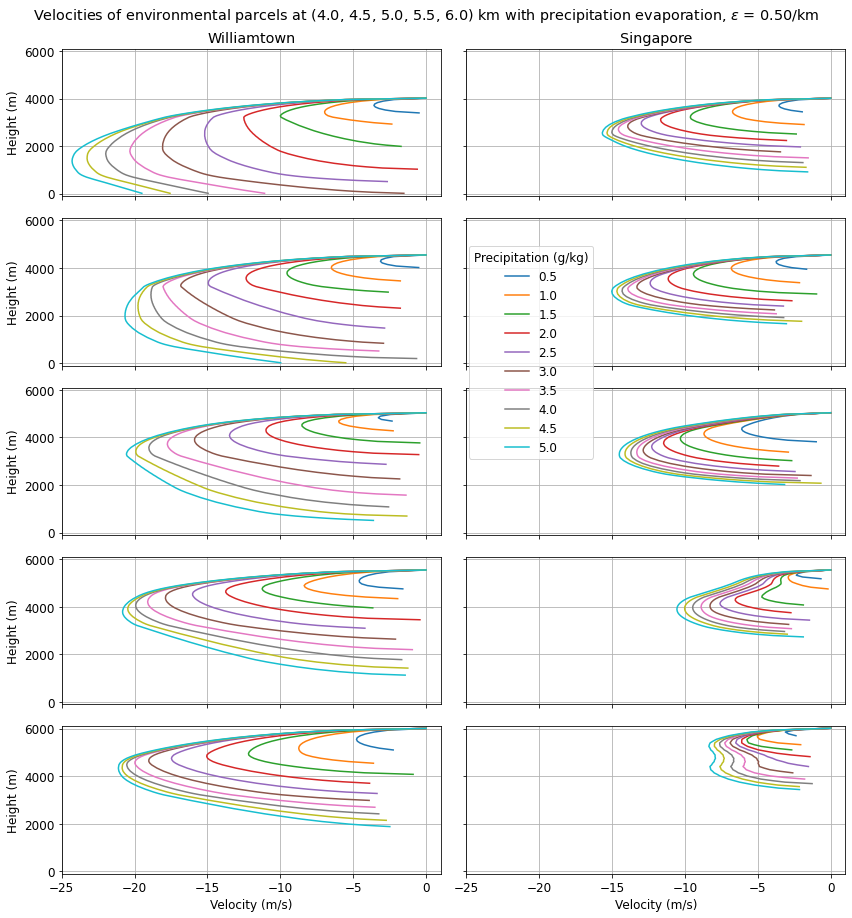

In [11]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(delta_Q.size):
        axes[i,0].plot(downdrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(downdrafts_sgp[i,j].velocity, z_sgp,
                       label='{:.1f}'.format(delta_Q[j].m*1e3))
for ax in axes.ravel():
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-25, 1)
    ax.set_ylim(-100, 6100)
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.55, 0.5))
lgd.set_title('Precipitation (g/kg)')
fig.suptitle(
    'Velocities of environmental parcels at (4.0, 4.5, 5.0, 5.5, 6.0) km '
    'with precipitation evaporation, $\epsilon$ = {:.2f}/km'.format(rate.m))
fig.tight_layout()

### Weak entrainment: $\epsilon$ = (10 km)$^{-1}$

In [12]:
%%time
z_init = np.arange(4.0, 6.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
delta_Q = np.arange(0.5e-3, 5.1e-3, 0.5e-3)*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.1/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km

downdrafts_wtown = np.empty((z_init.size, delta_Q.size), dtype='object')
downdrafts_sgp = np.empty((z_init.size, delta_Q.size), dtype='object')
n_done = 0
n_tot = z_init.size*delta_Q.size*2
for i in range(z_init.size):
    for j in range(delta_Q.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_wtown[i,j] = wtown.downdraft(
            i_init_wtown[i], delta_Q[j], w_initial, rate, dnu_db, drag)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_sgp[i,j] = sgp.downdraft(
            i_init_sgp[i], delta_Q[j], w_initial, rate, dnu_db, drag)
sys.stdout.write('\n')

Calculation 100 of 100     
CPU times: user 20.9 s, sys: 61.1 ms, total: 20.9 s
Wall time: 20.9 s


1

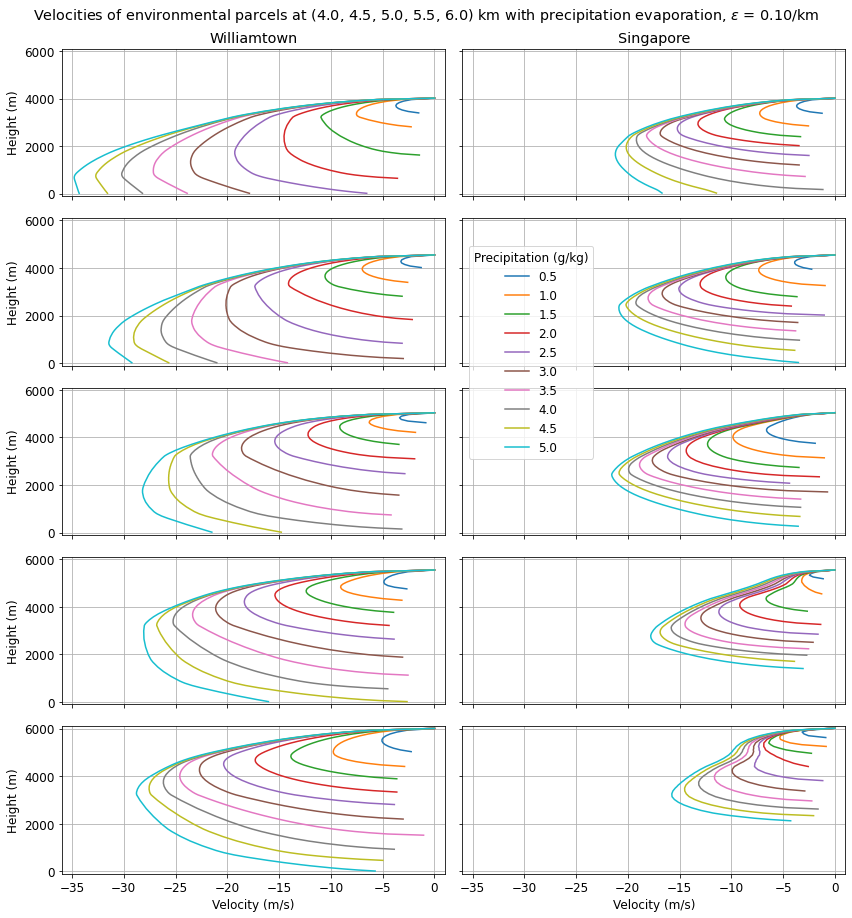

In [13]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(delta_Q.size):
        axes[i,0].plot(downdrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(downdrafts_sgp[i,j].velocity, z_sgp,
                       label='{:.1f}'.format(delta_Q[j].m*1e3))
for ax in axes.ravel():
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-36, 1)
    ax.set_ylim(-100, 6100)
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.55, 0.5))
lgd.set_title('Precipitation (g/kg)')
fig.suptitle(
    'Velocities of environmental parcels at (4.0, 4.5, 5.0, 5.5, 6.0) km '
    'with precipitation evaporation, $\epsilon$ = {:.2f}/km'.format(rate.m))
fig.tight_layout()

## Key observations
- Parcels with sufficiently large buoyancy perturbations may overcome CIN/DCIN and travel significantly further before coming to rest
- Parcels with similar initial conditions may have very different amounts of CAPE/DCAPE and CIN/DCIN at different initiation levels
- Choosing a weak entrainment rate may result in significant increases in velocity and distance ascended/descended, and a reduction in the initial buoyancy perturbation needed to overcome CIN/DCIN
    - This is consistent with the results of Sherwood et al. (2013), who used a homogeneous parcel but preferred this heterogeneous model
    - The magnitude of this effect also varies significantly between starting levels with different degrees of stability
- The velocities attained by downdrafts in the Singapore sounding were consistently smaller than those in the Williamtown sounding for the same initial amounts of evaporation, likely due to the higher humidity in Singapore

## Next steps
- Try larger drag
- Check 500m in Williamtown
    - Seems to be working as intended, weak updrafts are due to an inversion in the sounding. This is apparent after excluding the lowest few datapoints in the sounding where the temperature data seem unreliable. The surface and 500 m parcels must ascend through the inversion, while the parcels that start higher do not, allowing those parcels to ascend further.
- Couple updrafts to downdrafts
    - Read Julia's paper, references
- Tendencies
- Hidden variable: how to calculate it and use it to trigger convection

## Appendix: weak entrainment with drag, $\epsilon$ = $\epsilon_w$ = (10 km)$^{-1}$

For comparison with the results of Sherwood et al. (2013), we consider weakly entraining parcels whose drag coefficient is set equal to the entrainment rate.

The weakly entraining updrafts with drag still ascend much higher than the strongly entraining ones with no drag.

In [14]:
%%time
z_init = np.arange(0, 2.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
i_init_wtown[0] -= 3
i_init_sgp[0] -= 3
t_pert = np.arange(0.5, 3.1, 1.0)*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rates = 0.1/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
l_crit = 1e-3*units.dimensionless

updrafts_wtown = np.empty((z_init.size, t_pert.size), dtype='object')
updrafts_wtown_drag = np.empty((z_init.size, t_pert.size), dtype='object')
updrafts_sgp = np.empty((z_init.size, t_pert.size), dtype='object')
updrafts_sgp_drag = np.empty((z_init.size, t_pert.size), dtype='object')
n_done = 0
n_tot = z_init.size*t_pert.size*2*2
for i in range(z_init.size):
    for j in range(t_pert.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_wtown[i,j] = wtown.updraft(
            i_init_wtown[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, 0/units.km, l_crit)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_sgp[i,j] = sgp.updraft(
            i_init_sgp[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, 0/units.km, l_crit)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_wtown_drag[i,j] = wtown.updraft(
            i_init_wtown[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, rate, l_crit)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        updrafts_sgp_drag[i,j] = sgp.updraft(
            i_init_sgp[i], t_pert[j], q_pert, l_initial,
            w_initial, rate, dnu_db, rate, l_crit)
sys.stdout.write('\n')

Calculation 60 of 60     
CPU times: user 19.5 s, sys: 62.7 ms, total: 19.6 s
Wall time: 19.6 s


1

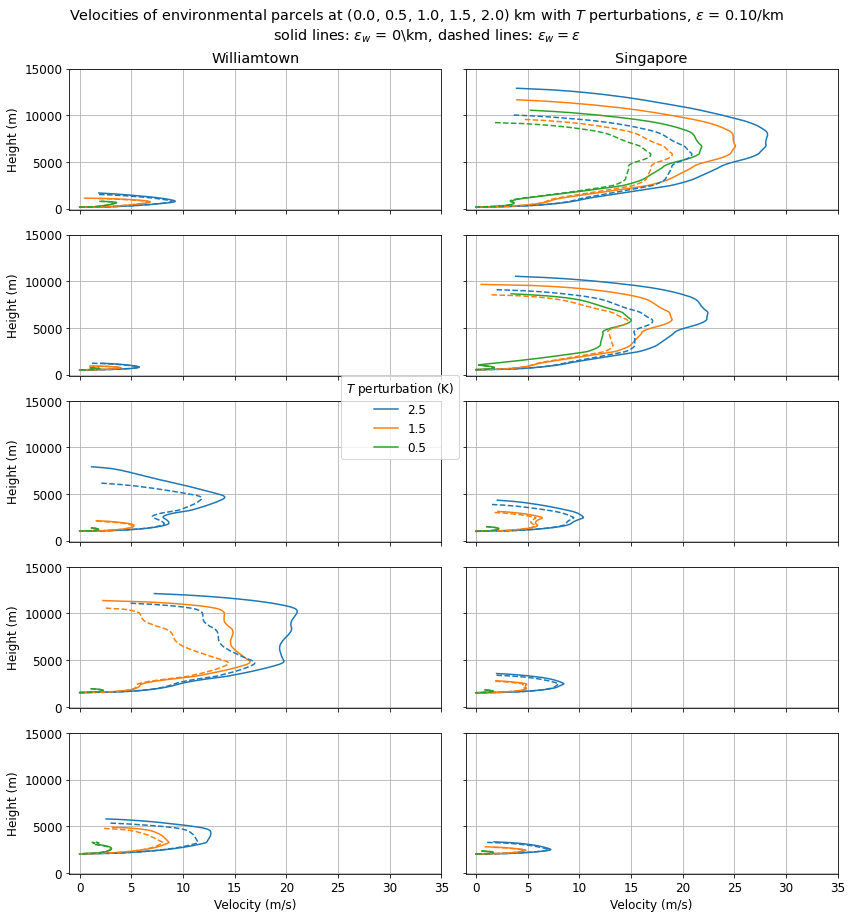

In [15]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(t_pert.size - 1, -1, -1):
        axes[i,0].plot(updrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(updrafts_sgp[i,j].velocity, z_sgp,
                       label='{:.1f}'.format(t_pert[j].m))
for ax in axes.ravel():
    ax.set_prop_cycle(None)
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-1, 35)
    ax.set_ylim(-100, 15000)
    
for i in range(z_init.size):
    for j in range(t_pert.size - 1, -1, -1):
        axes[i,0].plot(updrafts_wtown_drag[i,j].velocity, z_wtown, '--')
        axes[i,1].plot(updrafts_sgp_drag[i,j].velocity, z_sgp, '--')
    
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])

axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.4, 0.5))
lgd.set_title('$T$ perturbation (K)')
fig.suptitle(
    'Velocities of environmental parcels at (0.0, 0.5, 1.0, 1.5, 2.0) km '
    'with $T$ perturbations, $\epsilon$ = 0.10/km'
    '\nsolid lines: $\epsilon_w$ = 0\km, '
    'dashed lines: $\epsilon_w = \epsilon$')
fig.tight_layout()

In [16]:
%%time
z_init = np.arange(4.0, 6.1, 0.5)*units.km
i_init_wtown = z_wtown.size - 1 - np.searchsorted(z_wtown[::-1], z_init)
i_init_sgp = z_sgp.size - 1 - np.searchsorted(z_sgp[::-1], z_init)
delta_Q = np.arange(0.5e-3, 5.1e-3, 2e-3)*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.1/units.km
dnu_db = 1e-2*units.second**2/units.meter**2

downdrafts_wtown = np.empty((z_init.size, delta_Q.size), dtype='object')
downdrafts_wtown_drag = np.empty((z_init.size, delta_Q.size), dtype='object')
downdrafts_sgp = np.empty((z_init.size, delta_Q.size), dtype='object')
downdrafts_sgp_drag = np.empty((z_init.size, delta_Q.size), dtype='object')
n_done = 0
n_tot = z_init.size*delta_Q.size*2*2
for i in range(z_init.size):
    for j in range(delta_Q.size):
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_wtown[i,j] = wtown.downdraft(
            i_init_wtown[i], delta_Q[j], w_initial, rate, dnu_db, 0/units.km)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_sgp[i,j] = sgp.downdraft(
            i_init_sgp[i], delta_Q[j], w_initial, rate, dnu_db, 0/units.km)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_wtown_drag[i,j] = wtown.downdraft(
            i_init_wtown[i], delta_Q[j], w_initial, rate, dnu_db, rate)
        n_done += 1
        sys.stdout.write(f'\rCalculation {n_done} of {n_tot}     ')
        downdrafts_sgp_drag[i,j] = sgp.downdraft(
            i_init_sgp[i], delta_Q[j], w_initial, rate, dnu_db, rate)
sys.stdout.write('\n')

Calculation 60 of 60     
CPU times: user 12.4 s, sys: 49.3 ms, total: 12.5 s
Wall time: 12.5 s


1

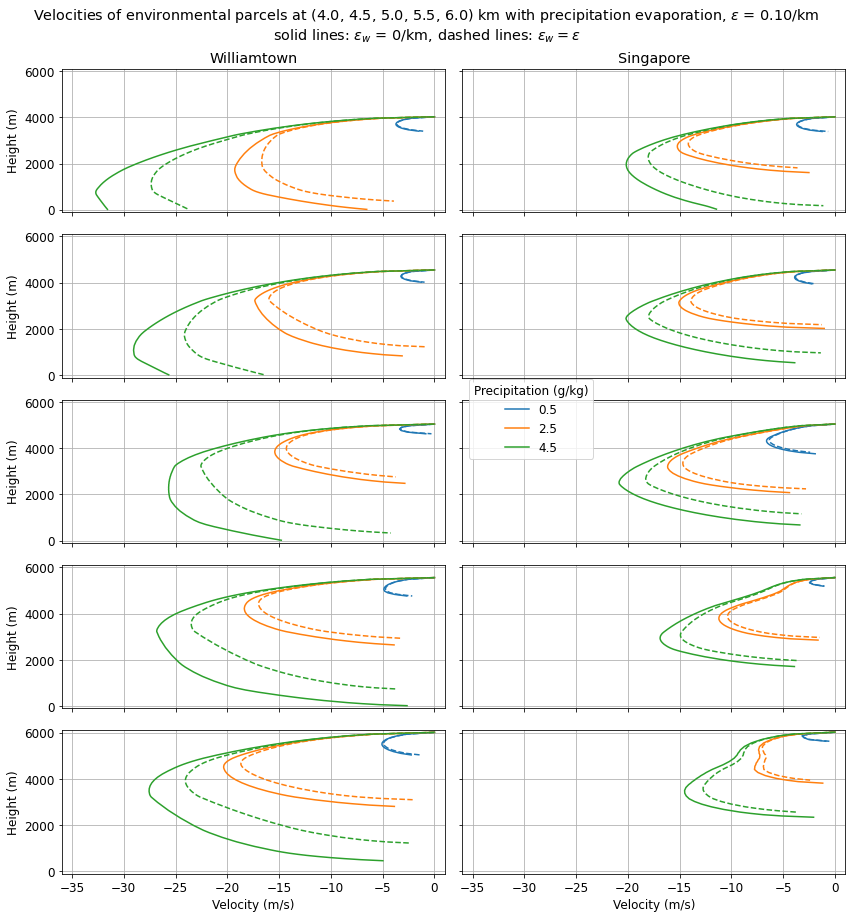

In [17]:
fig, axes = plt.subplots(z_init.size, 2, figsize=(12,13))
for i in range(z_init.size):
    for j in range(delta_Q.size):
        axes[i,0].plot(downdrafts_wtown[i,j].velocity, z_wtown)
        axes[i,1].plot(downdrafts_sgp[i,j].velocity, z_sgp,
                       label='{:.1f}'.format(delta_Q[j].m*1e3))
for ax in axes.ravel():
    ax.set_prop_cycle(None)
    ax.grid()
    ax.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
    ax.set_xlim(-36, 1)
    ax.set_ylim(-100, 6100)
    
for i in range(z_init.size):
    for j in range(delta_Q.size):
        axes[i,0].plot(downdrafts_wtown_drag[i,j].velocity, z_wtown, '--')
        axes[i,1].plot(downdrafts_sgp_drag[i,j].velocity, z_sgp, '--')
    
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
for ax in axes[:,1].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
axes[0,0].set_title('Williamtown')
axes[0,1].set_title('Singapore')
handles, labels = axes.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.55, 0.5))
lgd.set_title('Precipitation (g/kg)')
fig.suptitle(
    'Velocities of environmental parcels at (4.0, 4.5, 5.0, 5.5, 6.0) km '
    'with precipitation evaporation, $\epsilon$ = 0.10/km'
    '\nsolid lines: $\epsilon_w$ = 0/km, '
    'dashed lines: $\epsilon_w = \epsilon$')
fig.tight_layout()